<a href="https://colab.research.google.com/github/Lodakins/dl-ddos-attack-detection/blob/master/LSTM_CNN_3_IN_PROGRESS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
!pip install hyperopt
!pip install unidecode

In [84]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib
import seaborn as sns
import sklearn
import imblearn
import matplotlib.pyplot as plt
import time
from tensorflow import keras
import datetime as dt
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, f1_score, precision_score,recall_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding
from keras.layers import LSTM, SimpleRNN, GRU, Bidirectional, BatchNormalization,Convolution1D,MaxPooling1D, Reshape, GlobalAveragePooling1D
from keras.utils import to_categorical
import tensorflow as tf
import os
import warnings
warnings.filterwarnings('ignore')

In [37]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive


In [85]:
dataset_root = os.path.join(os.getcwd(),'Datasets/CICIDS2017')
#Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

df1=pd.read_csv(dataset_root+"/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")
df7=pd.read_csv(dataset_root+"/Wednesday-workingHours.pcap_ISCX.csv")

df = pd.concat([df1,df7])
del df1,df7

In [104]:
df.shape

(918448, 80)

In [87]:
len(list(df.columns))

79

In [105]:
df.columns = [ col.strip() for col in df]

In [89]:
#Function to min-max normalize
def normalize(df1, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode
    @return a DataFrame with normalized specified features
    """
    result = df1.copy() # do not touch the original df
    for feature_name in cols:
        max_value = df1[feature_name].max()
        min_value = df1[feature_name].min()
        if max_value > min_value:
            result[feature_name] = (df1[feature_name] - min_value) / (max_value - min_value)
    return result

In [106]:
attack_mapping={
    'DoS Hulk':'Ddos/Dos',
    'DDoS':'Ddos/Dos',
    'DoS GoldenEye':'Ddos/Dos',
    'DoS slowloris':'Ddos/Dos',
    'DoS Slowhttptest':'Ddos/Dos',
    'Heartbleed':'Ddos/Dos',
    'BENIGN':'Normal'
}

In [107]:
df['Label'].value_counts().head(20)

BENIGN              537749
DoS Hulk            231073
DDoS                128027
DoS GoldenEye        10293
DoS slowloris         5796
DoS Slowhttptest      5499
Heartbleed              11
Name: Label, dtype: int64

In [108]:
df.columns = [ col.strip() for col in df]

def map_attack(x):
  try:
    return attack_mapping[x]
  except:
    return "abnormal"


df['Label_category'] = df['Label'].map(lambda x: map_attack(x))

df['Label_category'].value_counts().head(10)

Normal      537749
Ddos/Dos    380699
Name: Label_category, dtype: int64

In [109]:
df_label_drop = df.drop(labels=['Label_category','Label'],axis=1)
label = df["Label_category"].values

# Split the data set into training and testing
new_df, X_test, Y_train, Y_test = train_test_split(df_label_drop,label, test_size=0.8, random_state=0, shuffle=True)

In [110]:
new_df['Label_category']=Y_train

In [111]:
new_df['Label_category'].value_counts().head(10)

Normal      107768
Ddos/Dos     75921
Name: Label_category, dtype: int64

In [112]:
new_df.shape

(183689, 79)

In [114]:
new_df.drop(['Fwd Header Length.1'],axis=1, inplace = True)
new_df.drop(['Bwd PSH Flags'],axis=1, inplace = True)
new_df.drop(['Bwd URG Flags'],axis=1, inplace = True)
new_df.drop(['Fwd Avg Bytes/Bulk'],axis=1, inplace = True)
new_df.drop(['Fwd Avg Packets/Bulk'],axis=1, inplace = True)
new_df.drop(['Fwd Avg Bulk Rate'],axis=1, inplace = True)
new_df.drop(['Bwd Avg Bytes/Bulk'],axis=1, inplace = True)
new_df.drop(['Bwd Avg Packets/Bulk'],axis=1, inplace = True)
new_df.drop(['Bwd Avg Bulk Rate'],axis=1, inplace = True)

In [113]:
new_df[['Flow Bytes/s', 'Flow Packets/s']] = new_df[['Flow Bytes/s', 'Flow Packets/s']].apply(pd.to_numeric)
df_num = new_df.select_dtypes(include='number')

df_num.columns

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Co

In [115]:
df_num.shape

(183689, 78)

In [116]:
tmp = new_df.pop('Label_category')
tmp.shape
tmp_list=  list(tmp)


new_df = normalize(df_num,df_num.columns)
new_df["Label_category"]=tmp_list

new_df.replace('Infinity', -1, inplace=True)
new_df.replace([np.inf, -np.inf, np.nan], -1, inplace=True)
new_df = new_df.dropna().reset_index()
new_df.drop(['index'],axis=1, inplace = True)

In [117]:
labelencoder = LabelEncoder()
new_df['Label_category'] = labelencoder.fit_transform(new_df['Label_category'])

In [118]:
new_df["Label_category"].head()

0    0
1    1
2    1
3    0
4    1
Name: Label_category, dtype: int64

In [119]:
new_df.shape

(183689, 79)

In [120]:
new_df["Label_category"].value_counts().head()

1    107768
0     75921
Name: Label_category, dtype: int64

In [121]:
new_df_label = new_df.drop(labels=['Label_category'],axis=1)
new_label = new_df["Label_category"].values

# Split the data set into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(new_df_label,new_label, test_size=0.3, random_state=0, shuffle=True)

In [122]:
X_train.shape

(128582, 78)

In [123]:
mutual_info = mutual_info_classif(X_train, Y_train)

mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
mutual_info.sort_values(ascending=False)

Destination Port               0.494729
Average Packet Size            0.493027
Avg Bwd Segment Size           0.489812
Bwd Packet Length Mean         0.489004
Subflow Bwd Bytes              0.484895
Total Length of Bwd Packets    0.484608
Bwd Packet Length Max          0.458694
Init_Win_bytes_forward         0.450968
Total Length of Fwd Packets    0.437560
Subflow Fwd Bytes              0.435233
Packet Length Std              0.420062
Packet Length Variance         0.417988
Packet Length Mean             0.417920
Fwd Packet Length Max          0.416234
Max Packet Length              0.399651
Bwd Header Length              0.372871
Fwd IAT Max                    0.361483
Init_Win_bytes_backward        0.354771
Bwd Packet Length Std          0.348014
Fwd IAT Total                  0.340258
Bwd Packets/s                  0.337836
Flow IAT Max                   0.336129
Fwd IAT Mean                   0.325203
Fwd Packet Length Mean         0.322752
Avg Fwd Segment Size           0.322303


<Axes: >

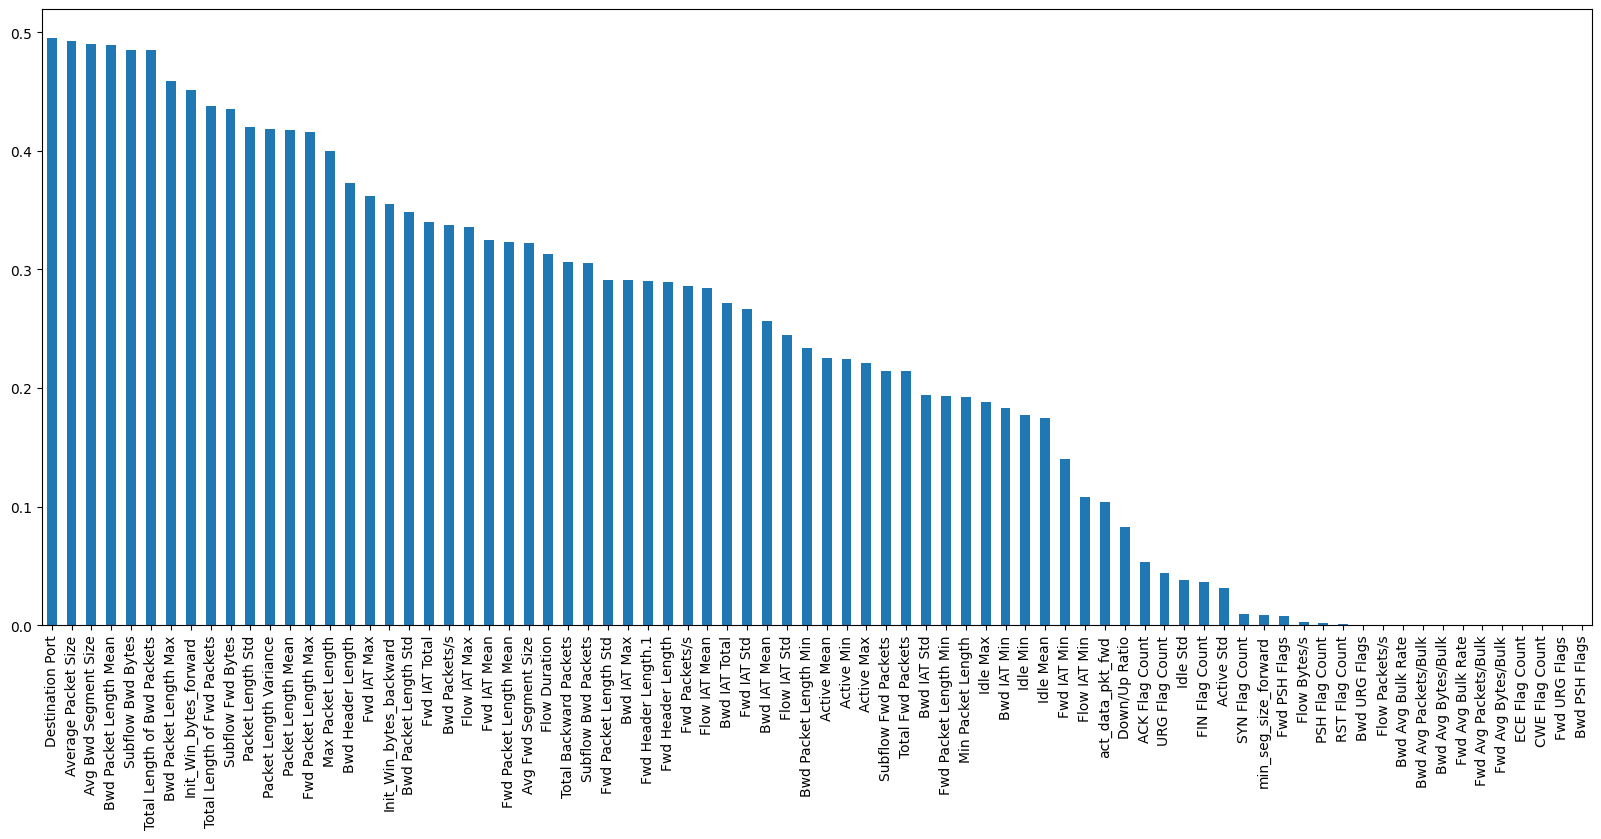

In [124]:
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 8))

In [125]:
# No we Will select the  top 40 important features
sel_five_cols = SelectKBest(mutual_info_classif, k=40)
sel_five_cols.fit(X_train, Y_train)
features=X_train.columns[sel_five_cols.get_support()]

In [126]:
scaler = StandardScaler()
X_train_np = scaler.fit_transform(X_train[features])
X_test_np= scaler.fit_transform(X_test[features])


X_train = np.reshape(X_train_np,(X_train_np.shape[0], X_train_np.shape[1], 1))

X_test = np.reshape(X_test_np,(X_test_np.shape[0], X_test_np.shape[1], 1))

X_test.shape

(55107, 40, 1)

In [127]:
#CNN-LSTM
batch_size = 32
model = Sequential()

model.add(Convolution1D(64, kernel_size=5, padding="same",activation="relu",input_shape=(X_train.shape[1],1)))
#model.add(MaxPooling1D(pool_length=(5)))

model.add(BatchNormalization())

model.add(LSTM(64, return_sequences=False))
model.add(Reshape((64, 1), input_shape = (64, )))

model.add(BatchNormalization())

model.add(LSTM(128, return_sequences=False))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(1)) #Output Layer
model.add(Activation('sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 40, 64)            384       
                                                                 
 batch_normalization_6 (Batc  (None, 40, 64)           256       
 hNormalization)                                                 
                                                                 
 lstm_6 (LSTM)               (None, 64)                33024     
                                                                 
 reshape_3 (Reshape)         (None, 64, 1)             0         
                                                                 
 batch_normalization_7 (Batc  (None, 64, 1)            4         
 hNormalization)                                                 
                                                                 
 lstm_7 (LSTM)               (None, 128)              

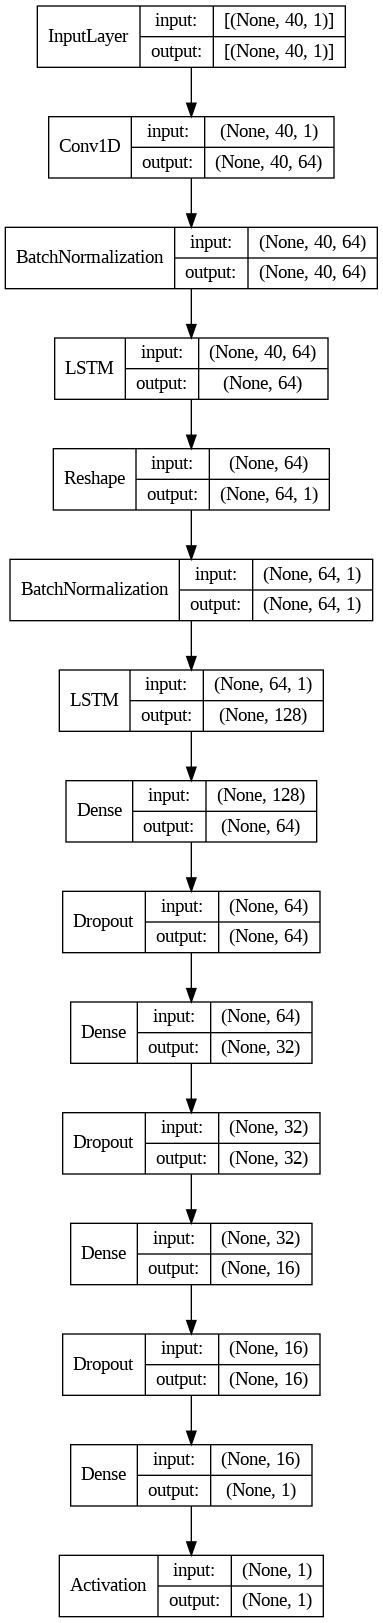

In [128]:
keras.utils.plot_model(
    model,
        show_shapes=True,
    show_dtype=False,
      show_layer_names=False,
)

In [129]:
model.compile(loss= "binary_crossentropy", optimizer= "adam",metrics = ["accuracy"])

In [130]:
history = model.fit(X_train, Y_train,
                              batch_size=128,
                              epochs=30,
                              verbose=True, #callbacks=[reduce_lr, early_stop_callback],
                              validation_data=(X_test, Y_test))

Epoch 1/30
1005/1005 [==============================] - 232s 226ms/step - loss: 0.1350 - accuracy: 0.9424 - val_loss: 0.0827 - val_accuracy: 0.9577
Epoch 2/30
1005/1005 [==============================] - 257s 256ms/step - loss: 0.0789 - accuracy: 0.9662 - val_loss: 0.1091 - val_accuracy: 0.9488
Epoch 3/30
1005/1005 [==============================] - 244s 243ms/step - loss: 0.0741 - accuracy: 0.9694 - val_loss: 0.0610 - val_accuracy: 0.9734
Epoch 4/30
1005/1005 [==============================] - 240s 239ms/step - loss: 0.0635 - accuracy: 0.9730 - val_loss: 0.0600 - val_accuracy: 0.9738
Epoch 5/30
1005/1005 [==============================] - 225s 224ms/step - loss: 0.0565 - accuracy: 0.9769 - val_loss: 0.0664 - val_accuracy: 0.9642
Epoch 6/30
1005/1005 [==============================] - 225s 224ms/step - loss: 0.0588 - accuracy: 0.9758 - val_loss: 0.0418 - val_accuracy: 0.9851
Epoch 7/30
1005/1005 [==============================] - 222s 221ms/step - loss: 0.0438 - accuracy: 0.9837 - val_

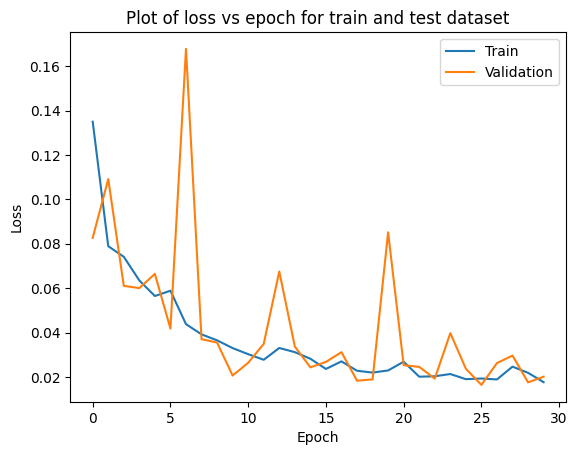

In [131]:
import seaborn as sn

# Plot of loss vs epoch of train and test dataset
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Plot of loss vs epoch for train and test dataset")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
#plt.savefig('plots/ae_binary_loss.png')
plt.show()

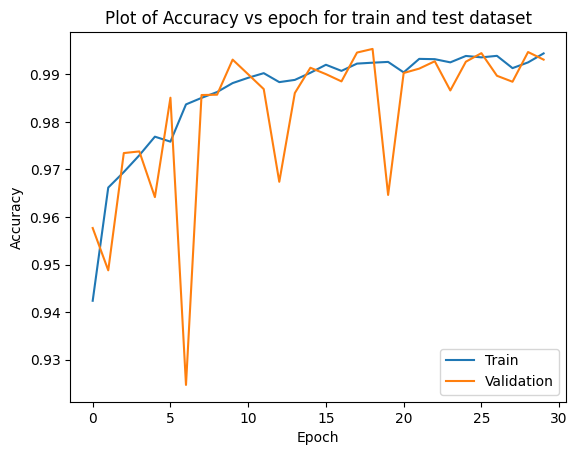

In [132]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Plot of Accuracy vs epoch for train and test dataset")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
#plt.savefig('plots/ae_binary_loss.png')
plt.show()

In [133]:
import time

# Measure inference time
start_time = time.time()
pred = model.predict(X_test)
end_time = time.time()

inference_time = end_time - start_time
print("Inference time: {:.2f} seconds".format(inference_time))

1723/1723 [==============================] - 56s 32ms/step
Inference time: 82.98 seconds


In [134]:
pred

array([[1.2779260e-07],
       [7.8792709e-08],
       [8.2869476e-05],
       ...,
       [9.9963713e-01],
       [9.9814159e-01],
       [7.4633874e-08]], dtype=float32)

In [136]:
y_preds = []
for i in pred :
  if i <0.5:
    y_preds.append(0)
  else:
    y_preds.append(1)

In [ ]:
y_preds

In [138]:
confMat = confusion_matrix(Y_test, y_preds)

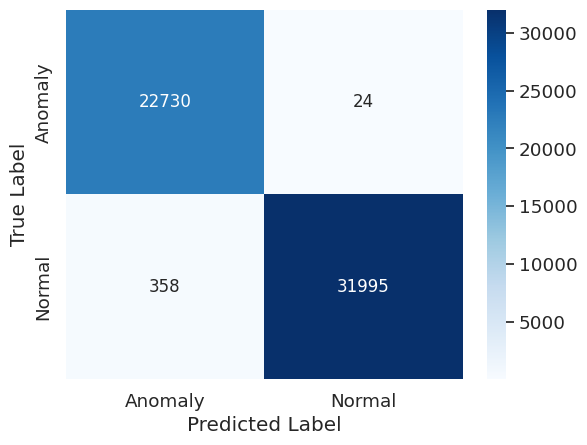

In [143]:
cm_df = pd.DataFrame(confMat)

labels = ['Anomaly','Normal']

#plt.figure(figsize=(20,15))
sn.set(font_scale=1.2)
sn.heatmap(cm_df, annot=True, annot_kws={"size":12}, fmt='g', xticklabels=labels, yticklabels=labels, cmap='Blues')

#sn.heatmap(cm_df, annot=True, annot_kws={"size":12}, fmt='g', xticklabels=labels, yticklabels=labels)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [142]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
start = dt.datetime.now()

escore = model.evaluate(X_test, Y_test, batch_size=32)
# pred = model.predict(X_test)
# pred = np.argmax(pred,axis=1)
# y_eval = np.argmax(Y_test,axis=1)

score = metrics.accuracy_score(Y_test, y_preds)
rscore = recall_score(Y_test, y_preds, average='weighted')
ascore = precision_score(Y_test, y_preds, average='weighted')
f1score= f1_score(Y_test, pred, average='weighted') #F1 = 2 * (precision * recall) / (precision + recall) for manual

lb = preprocessing.LabelBinarizer()
lb.fit(Y_test)
Y_test = lb.transform(Y_test)
y_preds = lb.transform(y_preds)
roc_score = roc_auc_score(Y_test, y_preds)

print('Completed')
print('Time taken:',dt.datetime.now()-start)

print("Validation score: {}".format(score))
print("Evaluation score: {}".format(escore))
print("Recall score: {}".format(rscore))
print("Precision score: {}".format(ascore))
print("F1 Measure score: {}".format(f1score))
# print("ROC-AUC score: {}".format(roc_score))

1723/1723 [==============================] - 55s 32ms/step - loss: 0.0201 - accuracy: 0.9931


ValueError: ignored